In [35]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [36]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:2


In [37]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [38]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,temp_total04,buoyancy,diffusivity,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.570472,0.000000,0.000037,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.575860,0.000271,0.000021,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.393058,0.000278,0.000021,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,11.130929,0.000185,0.000024,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106170,21,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,7.039837,0.000329,0.000019,7.039837,213,23,7.039837,7.039837,11.407,11.407
106171,22,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,6.216154,0.000227,0.000022,6.216154,213,23,6.216154,6.216154,11.407,11.407
106172,23,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,5.401328,0.000127,0.000029,5.401328,213,23,5.401328,5.401328,11.407,11.407
106173,24,28.094995,952.008506,-72.970251,-73.622512,0.0,0.543757,1.701971,0.004728,36000000.0,...,4.590689,0.000026,0.000037,4.590689,213,23,4.590689,4.590689,11.407,11.407


In [39]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 4247
Number of training points: 63700


# Normalizing Data

In [40]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [41]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'input_temp']
output_columns = ['diffusivity', 'temp_diff01']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [42]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (63700, 14), X_test: (42475, 14)
y_train: (63700, 2), y_test: (42475, 2)


In [43]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [44]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [45]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [46]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [47]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=14, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [48]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            pred = model(x)
            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|                                                                                 | 1/1000 [00:00<14:43,  1.13it/s]

Epoch : 0, Train_loss: 0.5888170387063708, Test_loss: 0.396618763250964


  5%|████                                                                            | 51/1000 [00:43<15:24,  1.03it/s]

Epoch : 50, Train_loss: 0.021683013879708828, Test_loss: 0.033541833593820534


 10%|███████▉                                                                       | 101/1000 [01:25<14:30,  1.03it/s]

Epoch : 100, Train_loss: 0.017922525316299426, Test_loss: 0.02942616447606789


 15%|███████████▉                                                                   | 151/1000 [02:07<13:38,  1.04it/s]

Epoch : 150, Train_loss: 0.016338297934640967, Test_loss: 0.03417276007322861


 20%|███████████████▉                                                               | 201/1000 [02:51<12:49,  1.04it/s]

Epoch : 200, Train_loss: 0.015094504942969671, Test_loss: 0.033956779388799554


 25%|███████████████████▊                                                           | 251/1000 [03:34<11:54,  1.05it/s]

Epoch : 250, Train_loss: 0.013803398014888876, Test_loss: 0.0368560040314194


 30%|███████████████████████▊                                                       | 301/1000 [04:17<11:22,  1.02it/s]

Epoch : 300, Train_loss: 0.012637398146565944, Test_loss: 0.042359459114127924


 35%|███████████████████████████▋                                                   | 351/1000 [05:00<10:27,  1.04it/s]

Epoch : 350, Train_loss: 0.011761072224804334, Test_loss: 0.051692123646803555


 40%|███████████████████████████████▋                                               | 401/1000 [05:43<09:39,  1.03it/s]

Epoch : 400, Train_loss: 0.010561230311554575, Test_loss: 0.047660620750061104


 45%|███████████████████████████████████▋                                           | 451/1000 [06:50<15:12,  1.66s/it]

Epoch : 450, Train_loss: 0.00971056088169534, Test_loss: 0.04424208522929499


 50%|███████████████████████████████████████▌                                       | 501/1000 [08:03<14:10,  1.70s/it]

Epoch : 500, Train_loss: 0.008406794031283684, Test_loss: 0.045303434216683466


 55%|███████████████████████████████████████████▌                                   | 551/1000 [09:18<13:48,  1.85s/it]

Epoch : 550, Train_loss: 0.008170052849140668, Test_loss: 0.044771757309458086


 60%|███████████████████████████████████████████████▍                               | 601/1000 [10:30<11:18,  1.70s/it]

Epoch : 600, Train_loss: 0.008342221201885314, Test_loss: 0.046110544802754054


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [11:43<09:52,  1.70s/it]

Epoch : 650, Train_loss: 0.00795330260954206, Test_loss: 0.04410178586286271


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [12:56<08:21,  1.68s/it]

Epoch : 700, Train_loss: 0.007799731061187765, Test_loss: 0.04411272942421159


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [13:51<04:01,  1.03it/s]

Epoch : 750, Train_loss: 0.007863250719974674, Test_loss: 0.04312145066381033


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [14:33<03:15,  1.02it/s]

Epoch : 800, Train_loss: 0.007677485478953237, Test_loss: 0.04560314177069813


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [15:15<02:24,  1.03it/s]

Epoch : 850, Train_loss: 0.007630682520804897, Test_loss: 0.045426035610338054


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [15:58<01:35,  1.03it/s]

Epoch : 900, Train_loss: 0.007367753597449452, Test_loss: 0.043034503541310276


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [16:41<00:47,  1.03it/s]

Epoch : 950, Train_loss: 0.007334398039217506, Test_loss: 0.044768416200808826


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:23<00:00,  1.04s/it]


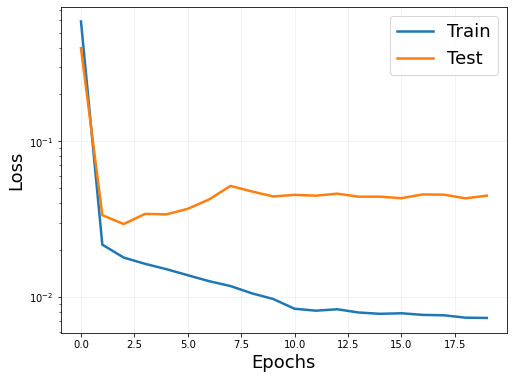

In [49]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [50]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_diff = rmse(y_[:,0], pred_[:,0])
    rmse_temp = rmse(y_[:,1], pred_[:,1])
    
    l2_error_diff = l2_error(y_[:,0], pred_[:,0])
    l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    return rmse_diff, rmse_temp, l2_error_diff, l2_error_temp

In [51]:
rmse_diff, rmse_temp, l2_error_diff, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Diffusivity: {rmse_diff}")
print(f"Test Rmse of Temp: {rmse_temp}")

print(f"L2 Error of Diffusivity: {l2_error_diff}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Diffusivity: 3.182728993928569e-06
Test Rmse of Temp: 0.2687863437812775
L2 Error of Diffusivity: 0.1635207090732862
L2 Error  of Temp: 0.016408331327915734


In [52]:
rmse_diff, rmse_temp, l2_error_diff, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Diffusivity: {rmse_diff}")
print(f"Train Rmse of Temp: {rmse_temp}")

print(f"L2 Error of Diffusivity: {l2_error_diff}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Diffusivity: 1.2931323558168827e-06
Train Rmse of Temp: 0.10161706496382798
L2 Error of Diffusivity: 0.05824200018764792
L2 Error  of Temp: 0.007151337215040982


# Saving Model

In [53]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [54]:
output_mean

array([1.93613008e-05, 1.24679478e+01])